# Week 5: Pretraining Powerhouse

We are almost done! Out GPT just waits for training and will be ready for inference. So in this notebook, we'll review
- how to prepare text data for GPT training
- how our GPT model can learn and optimize itself
- The training process, including forward and backward passes.

Let's get it started!

In [1]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence

import tiktoken
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import yaml
from typing import List, Literal, Tuple, Dict, Optional, Any

from src.multiattention import MultiHeadAttention 
from src.transformerblock import TransformerBlock
from src.gpt import PseudoGPT
from helpers.check_todo import check_implementation


device = "cuda" if torch.cuda.is_available() else "cpu"



In [2]:
import sys
sys.path.append('src')

## 1. Preparing Text Data

Now we will be building the class responsible for preparing the text data. It will tokenize the text file and create overlapping sequences of tokens for our PseudoGPT model to learn from.

Let's say we have this text: `"Hello, the world of LLM Trailblazers!"`. On  this stage for `class TextDataset` we will need:
1. Tokenizer (we'll stick to `tiktoken` here but feel free to re-use what we have previously built)

After tokenization, it might look something like this (these are made-up token IDs):
[15, 20, 7, 35, 12, 45, 8, 60, 75, 3]

2. Block size definition

It is the length of the sequences that the model will process. It determines how much context the model sees at once. For example, if block_size is 64, the model will work with sequences of 64 tokens at a time.

3. Sliding window approach with overlapping input-output pairs
   
Let's say our block_size is 5. The idea is that given the sequence/chunk [15, 20, 7, 35, 12], the model should predict [20, 7, 35, 12, 45].
This sliding window approach allows the model to learn the relationships between tokens in the text.

In [3]:
# TODO: Use your example text
with open('data/your_text_file.txt', 'r') as file:
    text = file.readline().strip()

print("The first line of the file:\n", text)

The first line of the file:
 Hello, the world of LLM Trailblazers!


In [4]:
# Tokenize the text
tokenizer = tiktoken.get_encoding("gpt2")
tokens = tokenizer.encode(text)

# Set block_size
block_size = 4

# Create a function to get chunks with a sliding window
def get_chunks(idx: int, tokens: List[int], block_size: int) -> Tuple[List[int], List[int]]:
    input_chunk = tokens[idx : idx + block_size]
    target_chunk = tokens[idx + 1 : idx + block_size + 1]
    return input_chunk, target_chunk

In [5]:
# Create a DataFrame to display the results
data = []
for idx in range(len(tokens) - block_size):
    input_chunk, target_chunk = get_chunks(idx, tokens, block_size)
    input_text = tokenizer.decode(input_chunk)
    target_text = tokenizer.decode(target_chunk)
    data.append({
        'idx': idx,
        'input_chunk': input_chunk,
        'input_text': input_text,
        'target_chunk': target_chunk,
        'target_text': target_text
    })

df = pd.DataFrame(data)

In [6]:
display(df)

print("\nOriginal tokens:")
print(tokens)
print("\nOriginal text:")
print(tokenizer.decode(tokens))

,idx,input_chunk,input_text,target_chunk,target_text
0,0,"[15496, 11, 262, 995]","Hello, the world","[11, 262, 995, 286]",", the world of"
1,1,"[11, 262, 995, 286]",", the world of","[262, 995, 286, 27140]",the world of LL
2,2,"[262, 995, 286, 27140]",the world of LL,"[995, 286, 27140, 44]",world of LLM
3,3,"[995, 286, 27140, 44]",world of LLM,"[286, 27140, 44, 13069]",of LLM Trail
4,4,"[286, 27140, 44, 13069]",of LLM Trail,"[27140, 44, 13069, 2436]",LLM Trailbl
5,5,"[27140, 44, 13069, 2436]",LLM Trailbl,"[44, 13069, 2436, 1031]",M Trailblaz
6,6,"[44, 13069, 2436, 1031]",M Trailblaz,"[13069, 2436, 1031, 364]",Trailblazers
7,7,"[13069, 2436, 1031, 364]",Trailblazers,"[2436, 1031, 364, 0]",blazers!



Original tokens:
[15496, 11, 262, 995, 286, 27140, 44, 13069, 2436, 1031, 364, 0]

Original text:
Hello, the world of LLM Trailblazers!


Now that we can see the input and output chunks, we can also check how our `TextDataset` looks like:

In [7]:
class TextDataset(Dataset):
    def __init__(self, text: str, block_size: int, tokenizer: Any):
        self.tokenizer = tokenizer
        self.block_size = block_size
        self.data = self.tokenizer.encode(text)

    def __len__(self) -> int:
        return len(self.data) - self.block_size

    def get_chunks(self, idx: int) -> Tuple[List[int], List[int]]:
        input_chunk = self.data[idx : idx + self.block_size]
        target_chunk = self.data[idx + 1 : idx + self.block_size + 1]
        return input_chunk, target_chunk

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        input_chunk, target_chunk = self.get_chunks(idx)
        x = torch.tensor(input_chunk, dtype=torch.long)
        y = torch.tensor(target_chunk, dtype=torch.long)
        return x, y

We can consider adding a sliding window of stride to it but the code and data preprocessing will work also with the previous implementation.

In [8]:
class TextDataset(Dataset):
    def __init__(self, text: str, block_size: int, tokenizer: Any, stride: int = 1):
        self.tokenizer = tokenizer
        self.block_size = block_size
        self.stride = stride
        self.data = self.tokenizer.encode(text)

    def __len__(self) -> int:
        
        return max(0, (len(self.data) - self.block_size) // self.stride + 1)

    def get_chunks(self, idx: int) -> Tuple[List[int], List[int]]:

        # TODO: Add stride
        # Hint: our initial index will now be different
        
        start_idx = idx * self.stride
        end_idx = start_idx + self.block_size
        
        input_chunk = self.data[start_idx:end_idx]
        target_chunk = self.data[start_idx + 1:end_idx + 1]

        return input_chunk, target_chunk

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        input_chunk, target_chunk = self.get_chunks(idx)
        
        x = torch.tensor(input_chunk, dtype=torch.long)
        y = torch.tensor(target_chunk, dtype=torch.long)
        return x, y

In [9]:
try:
    check_implementation(TextDataset)
except NotImplementedError as e:
    print(e)

'get_chunks' in class 'TextDataset' contains a TODO placeholder and must be implemented.


In [10]:
with open('data/your_text_file.txt', 'r') as file:
    textfile = file.read()

In [11]:
tokenizer = tiktoken.get_encoding("gpt2")
block_size = 4
stride = 2  # You can adjust this value

dataset = TextDataset(textfile, block_size, tokenizer, stride)
dataset[0]

(tensor([15496,    11,   262,   995]), tensor([ 11, 262, 995, 286]))

And now we can review how dataset can turned into DataLoader with certain batches of data.

In [12]:
# TODO: recall why we needed to pad sequences from our exercises on tokenization
def collate_fn(batch: List[Tuple[torch.Tensor, torch.Tensor]]) -> Tuple[torch.Tensor, torch.Tensor]:
    # Separate the input sequences and targets
    sequences, targets = zip(*batch)
    
    # Pad the sequences
    padded_sequences = pad_sequence(sequences, batch_first=True, padding_value=0)
    
    # Pad the targets if they are sequences, otherwise just stack them
    if isinstance(targets[0], torch.Tensor) and targets[0].dim() > 0:
        padded_targets = pad_sequence(targets, batch_first=True, padding_value=0)
    else:
        padded_targets = torch.stack(targets)
    
    return padded_sequences, padded_targets

In [13]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=64, collate_fn=collate_fn)

In [14]:
for batch in train_dataloader:
    inputs, targets = batch
    print("Input:", inputs)
    print("Target:", targets)
    break

Input: tensor([[ 2785,  5479,   286,   777],
        [   11,   290,   262, 12779],
        [  269, 17723,   286,   649],
        [ 4953,   329,   534,  9284],
        [  290,  3644,  3783,    11],
        [  777,  8514,    13, 22852],
        [   11,   262,  2785,   329],
        [ 3341,    11,  8776,   319],
        [  790,  2746,   345,  4512],
        [39738,    11,   290,  8876],
        [  318,   987, 40625,   416],
        [  357,  8645,   876,  3771],
        [15496,    11,   262,   995],
        [ 3047,  1366,    11,   262],
        [   13,   770, 40826,   286],
        [   12, 33215, 10375,    13],
        [ 4673,    13,   383,   995],
        [ 7796,   262, 13215,   286],
        [ 7716,  2438,   287,  2972],
        [ 1394, 13504,    11,  1394],
        [ 3294, 18333,    11,  3756],
        [ 3969,    11, 39738,    11],
        [   13,   198,   198,   464],
        [  284,   517, 12373,   290],
        [   11, 11409,    11,  6491],
        [   11,   290,   790,  1917],
     

## 2. Passing Forward and Backward

**Forward Pass** is the step where the input is passed through the model to obtain predictions. It computes the logits or output values.

```python
logits = model(input_sequence)
loss = loss_fn(logits, target_sequence)
````

``logits`` are the raw prediction scores from the model, and ``loss`` is calculated based on the difference between the predicted outputs (``logits``) and the actual targets (``target_sequence``).

Let's say we have a very small vocabulary of 3 words: ["Hello", "LLM", "Trailblazer"]
We're training a model to predict the next word given a sequence of words.

Suppose our model predicts probabilities for the next word after "Hello":
- Model output (logits after softmax):
["Hello": 0.1, "LLM": 0.2, "Trailblazer": 0.4]
- True next word: "LLM"
- In case of using CrossEntropy function for loss calculation: `loss = -log(probability of correct word)`:

loss = -log(0.2) ≈ 0.699

This loss value tells us how far off our prediction was from the correct answer. Lower loss means better prediction.

In [15]:
logits = torch.tensor([[2.0, 2.5, 3.0]])  # shape: [1, 3]

# True label (index of "LLM")
target = torch.tensor([1])

loss_fn = nn.CrossEntropyLoss()
loss = loss_fn(logits, target)
print(f"Loss: {loss.item()}")

Loss: 1.180269718170166


In **Backward Pass** step, gradients are computed using the loss from the forward pass. The ``loss.backward()`` function calculates the gradient of the loss with respect to all the learnable parameters in the model.

```python
optimizer.zero_grad()   # Clear previous gradients
loss.backward()         # Compute gradients
optimizer.step()        # Update model parameters
```

Now, let's see how the gradient-descent optimization algorithm, e.g. Adam, would update the model parameters based on this loss.

``model.train()`` sets the model in training mode. It tells the model that it's in training mode, which affects certain layers like dropout and batch normalization that behave differently during training and evaluation.

```python
model.train()
```

``model.eval()`` sets the model in evaluation mode. Dropout will be disabled. When a model is being used to make predictions, batch normalization layers use the mean and variance of the training data  instead of calculating new ones from the input data, making the process more stable and reliable.

```python
model.eval()
```

``torch.no_grad()`` is a context manager used to perform computations without tracking gradients, which reduces memory consumption and speeds up computation when you are not training (e.g., evaluation/inference).

In [16]:
# Simplified tokenization
vocab = ['Hello', 'the', 'world', 'of', 'LLM', 'Trailblazers', '!', '<unk>']
word_to_ix = {word: i for i, word in enumerate(vocab)}
tokens = [word_to_ix.get(word, word_to_ix['<unk>']) for word in text.split()]

# Create input-target pairs
input_sequence = torch.tensor(tokens[:-1])
target_sequence = torch.tensor(tokens[1:])

In [17]:
class SimpleLanguageModel(nn.Module):
    def __init__(self, vocab_size: int, embedding_dim: int):
            super().__init__()
            self.embedding = nn.Embedding(vocab_size, embedding_dim)
            self.linear = nn.Linear(embedding_dim, vocab_size)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear(self.embedding(x))

model = SimpleLanguageModel(len(vocab), embedding_dim=10)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [18]:
target_sequence.dtype

torch.int64

In [19]:
for epoch in range(5):
    # Set the model to training mode
    model.train()
    
    # Forward pass
    logits = model(input_sequence)
    loss = loss_fn(logits, target_sequence)
    
    # Backward pass
    optimizer.zero_grad()   # Reset gradients
    loss.backward()         # Compute gradients
    optimizer.step()        # Update model parameters
    
    # Print current state
    print(f"Epoch {epoch}:")
    print(f"  Loss: {loss.item():.4f}")
    
    # Evaluation - do not compute gradients
    model.eval()
    with torch.no_grad():
        probs = torch.softmax(logits[0], dim=0)
        for word, prob in zip(vocab, probs):
            print(f"    {word}: {prob.item():.4f}")

Epoch 0:
  Loss: 2.2084
    Hello: 0.0371
    the: 0.0306
    world: 0.0572
    of: 0.2777
    LLM: 0.0423
    Trailblazers: 0.2235
    !: 0.1490
    <unk>: 0.1826
Epoch 1:
  Loss: 2.1145
    Hello: 0.0370
    the: 0.0342
    world: 0.0577
    of: 0.2835
    LLM: 0.0446
    Trailblazers: 0.2173
    !: 0.1455
    <unk>: 0.1802
Epoch 2:
  Loss: 2.0232
    Hello: 0.0369
    the: 0.0381
    world: 0.0582
    of: 0.2880
    LLM: 0.0471
    Trailblazers: 0.2114
    !: 0.1422
    <unk>: 0.1781
Epoch 3:
  Loss: 1.9344
    Hello: 0.0368
    the: 0.0426
    world: 0.0588
    of: 0.2906
    LLM: 0.0496
    Trailblazers: 0.2060
    !: 0.1392
    <unk>: 0.1764
Epoch 4:
  Loss: 1.8482
    Hello: 0.0367
    the: 0.0475
    world: 0.0594
    of: 0.2921
    LLM: 0.0523
    Trailblazers: 0.2008
    !: 0.1363
    <unk>: 0.1749


In [20]:
def train(model: nn.Module, input_sequence: torch.Tensor, target_sequence: torch.Tensor, 
            loss_fn: nn.Module, optimizer: optim.Optimizer) -> float:
      # TODO: finalize train()

      # Hint: 1. Set the model to training mode
      # 2. Pass input_sequence through model 
      # 3. Compare the logits wuth target_sequece using loss function
      # 4. Run backward pass
      # 5. Return loss.item()

      model.train()
      optimizer.zero_grad()
      logits = model(input_sequence)
      loss = loss_fn(logits, target_sequence)
      loss.backward()
      optimizer.step()
      
      print(f" Loss: {loss.item():.4f}")
      
      return loss.item()
      

In [21]:
try:
    check_implementation(train)
except NotImplementedError as e:
    print(e)

'train' contains a TODO placeholder and must be implemented.


In [22]:
class Accuracy: ## torchmetrics
    def __init__(self):
        self.num_total = 0
        self.num_correct = 0

    def update(self, logits, y):
        preds = torch.softmax(logits, dim=-1)
        self.num_total += preds.shape[0]
        self.num_correct += torch.sum(preds.argmax(axis=1) == y).cpu().item()

    def get_metric(self):
        return {'acc': 0. if self.num_total == 0 else self.num_correct / self.num_total}

    def get_primary_metric(self):
        return self.get_metric()['acc']


In [23]:
def evaluate(model: nn.Module, input_sequence: torch.Tensor, vocab: List[str]) -> torch.Tensor:
    # TODO: finalize evaluate()
    
    # Hint: 1. Set the model to evaluation mode
    # 2. Set the computation to be without gradients
    # 3. Pass input_sequence through model 
    # 4. Apply softmax along batch dimension for the model output with the first element
    
    model.eval()
    with torch.no_grad():
        x = model(input_sequence)
        x = torch.softmax(x, dim=-1)
    return x

In [24]:
try:
    check_implementation(evaluate)
except NotImplementedError as e:
    print(e)

'evaluate' contains a TODO placeholder and must be implemented.


In [25]:
for epoch in range(5):
    print(f"Epoch {epoch+1}:")
    
    # Train the model
    loss = train(model, input_sequence, target_sequence, loss_fn, optimizer)
    print(f"Loss: {loss:.4f}")
    
    # Evaluate the model
    preds = evaluate(model, input_sequence, vocab)
    print(f"{preds[0]}")

Epoch 1:
 Loss: 1.7645
Loss: 1.7645
tensor([0.0366, 0.0587, 0.0603, 0.2931, 0.0577, 0.1909, 0.1307, 0.1721])
Epoch 2:
 Loss: 1.6834
Loss: 1.6834
tensor([0.0365, 0.0650, 0.0605, 0.2929, 0.0604, 0.1860, 0.1279, 0.1708])
Epoch 3:
 Loss: 1.6048
Loss: 1.6048
tensor([0.0363, 0.0719, 0.0606, 0.2923, 0.0631, 0.1812, 0.1251, 0.1694])
Epoch 4:
 Loss: 1.5288
Loss: 1.5288
tensor([0.0362, 0.0793, 0.0606, 0.2913, 0.0657, 0.1764, 0.1223, 0.1680])
Epoch 5:
 Loss: 1.4554
Loss: 1.4554
tensor([0.0361, 0.0873, 0.0605, 0.2900, 0.0682, 0.1717, 0.1195, 0.1666])


## 4. Bring It All Together

#### Hyperparameters Explained
Let's review what hyperparameters we have already used and will add to our config file.

- `vocab_size`: The size of the model's vocabulary. Larger vocabularies can capture more nuanced language but require more computational resources.
- `d_model`: Dimension of the model's embeddings and hidden states. Larger values increase model capacity but also computational cost.
- `num_heads`: Number of attention heads in multi-head attention layers. More heads can capture different types of dependencies in the input.
- `num_layers`: Number of transformer blocks in the model. More layers increase model depth and capacity.
- `d_ff`: Dimension of the feed-forward layer in transformer blocks. Larger values increase model capacity.
- `max_seq_length`: Maximum sequence length the model can handle. Longer sequences allow for more context but increase memory usage.
- `dropout`: Dropout rate for regularization. Higher values can prevent overfitting but may slow down training.
- `batch_size`: Number of samples processed in each training step. Larger batches can lead to more stable gradients but require more memory.
- `num_epochs`: Number of times the model will see the entire dataset during training.
- `learning_rate`: Step size at each iteration while moving toward a minimum of the loss function.

In [26]:
%%writefile config.yaml

# Model parameters
vocab_size: 50257  # GPT-2 tokenizer vocabulary size
d_model: 256
num_heads: 8
num_layers: 6
d_ff: 1024
max_seq_length: 128
dropout: 0.1

# Training parameters
batch_size: 64
num_epochs: 2 # we set to a low value
learning_rate: 3e-4

# TODO: use your text file
data_path: "data/your_text_file.txt"

Overwriting config.yaml


In [46]:
class Trainer:
    def __init__(self, config: Dict[str, Any], device: Literal["cpu", "cuda"]="cuda"):
        self.config = config
        self.device = device
        print(f"Loaded on {self.device}")
        self.tokenizer = tiktoken.get_encoding("gpt2")
        
        self.model = PseudoGPT(
            vocab_size=config['vocab_size'],
            d_model=config['d_model'],
            num_heads=config['num_heads'],
            num_layers=config['num_layers'],
            d_ff=config['d_ff'],
            max_seq_length=config['max_seq_length'],
            dropout=config['dropout']
        ).to(self.device)
        
        self.criterion = nn.CrossEntropyLoss().to(self.device)

        print(f"Learning rate: {config['learning_rate']}, Type: {type(config['learning_rate'])}")
        
        self.optimizer = optim.Adam(self.model.parameters(), lr=config['learning_rate'])

    def load_data(self, file_path: str) -> None:
        with open(file_path, "r", encoding="utf-8") as f:
            text = f.read()
        
        dataset = TextDataset(text, self.config['max_seq_length'], self.tokenizer)
        train_size = int(0.8 * len(dataset))
        val_size = len(dataset) - train_size
        train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
        
        self.train_dataloader = DataLoader(train_dataset, batch_size=self.config['batch_size'], shuffle=True, collate_fn=collate_fn)
        self.val_dataloader = DataLoader(val_dataset, batch_size=self.config['batch_size'], collate_fn=collate_fn)

    def train(self) -> Tuple[List[float], List[float]]:
        train_losses = []
        val_losses = []
       
        
        # TODO: Integrate loops around batches for train()
        
        # Hint: Use # of epochs set in the config
        # Iterate around batches within train_dataloader
        # Calculate average train loss per batch using train_dataloader length
        # Call evaluate() for average validation loss
        
        num_epochs =  self.config["num_epochs"]
        for epoch in range(num_epochs):
            epoch_train_loss = 0.0
            for inputs, targets in self.train_dataloader:    
                inputs, targets = inputs.to(self.device), targets.to(self.device)            
                
                self.model.train()
                self.optimizer.zero_grad()
                
                logits = self.model(inputs)

                loss = self.criterion(logits.flatten(0, 1), targets.flatten())
                loss.backward()
                self.optimizer.step()
                
                epoch_train_loss += loss.item()
                
            avg_train_loss = epoch_train_loss / len(self.train_dataloader)
            train_losses.append(avg_train_loss)
        
            avg_val_loss = self.evaluate()
            val_losses.append(avg_val_loss)

            print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

        return train_losses, val_losses

    def evaluate(self) -> float:
                
        # TODO: Integrate loops around batches for evaluate()

        # Hint: Iterate around batches within val_dataloader
        # Return average val loss per batch using val_dataloader length
        
        self.model.eval()
        epoch_val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in self.val_dataloader:
                inputs, targets = inputs.to(self.device), targets.to(self.device)    
                
                logits = self.model(inputs)
                loss = self.criterion(logits.flatten(0, 1), targets.flatten())
                
                epoch_val_loss += loss.item() 
        
        return epoch_val_loss / len(self.val_dataloader)
        

    def plot_losses(self, train_losses: List[float], val_losses: List[float]) -> None:
        plt.figure(figsize=(10, 5))
        plt.plot(train_losses, label='Train Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training and Validation Losses')
        plt.legend()
        plt.savefig('loss_plot.png')
        plt.show()
        plt.close()

    def plot_token_probabilities(self, input_text: str) -> None:
        self.model.eval()
        input_ids = torch.tensor(self.tokenizer.encode(input_text)).unsqueeze(0).to(self.device)
        with torch.no_grad():
            outputs = self.model(input_ids)
        
        probs = torch.softmax(outputs[0, -1], dim=-1)
        top_k = 10
        top_probs, top_indices = torch.topk(probs, top_k)
        
        top_tokens = [self.tokenizer.decode([idx.item()]) for idx in top_indices]
        
        plt.figure(figsize=(12, 6))
        plt.bar(top_tokens, top_probs.cpu().numpy())
        plt.title(f"Top {top_k} Token Probabilities for Next Token")
        plt.xlabel("Tokens")
        plt.ylabel("Probability")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig('token_probabilities.png')
        plt.show()
        plt.close()

    def save_model(self, path: str) -> None:
        torch.save(self.model.state_dict(), path)

In [28]:
try:
    check_implementation(Trainer)
except NotImplementedError as e:
    print(e)

'evaluate' in class 'Trainer' contains a TODO placeholder and must be implemented.
'train' in class 'Trainer' contains a TODO placeholder and must be implemented.


In [29]:
def load_config(config_path: str) -> Dict[str, Any]:
    with open(config_path, 'r') as f:
        config = yaml.safe_load(f)
    config['learning_rate'] = float(config['learning_rate'])
    return config

Loaded on cuda
Learning rate: 0.0003, Type: <class 'float'>
Epoch 1/20, Train Loss: 10.1926, Validation Loss: 9.3599
Epoch 2/20, Train Loss: 9.0150, Validation Loss: 8.5393
Epoch 3/20, Train Loss: 8.2172, Validation Loss: 7.6471
Epoch 4/20, Train Loss: 7.2998, Validation Loss: 6.7049
Epoch 5/20, Train Loss: 6.4831, Validation Loss: 5.8732
Epoch 6/20, Train Loss: 5.6311, Validation Loss: 5.1401
Epoch 7/20, Train Loss: 4.9847, Validation Loss: 4.4790
Epoch 8/20, Train Loss: 4.3764, Validation Loss: 3.9069
Epoch 9/20, Train Loss: 3.8662, Validation Loss: 3.4051
Epoch 10/20, Train Loss: 3.3741, Validation Loss: 2.9736
Epoch 11/20, Train Loss: 2.9751, Validation Loss: 2.6038
Epoch 12/20, Train Loss: 2.6253, Validation Loss: 2.2852
Epoch 13/20, Train Loss: 2.3225, Validation Loss: 2.0154
Epoch 14/20, Train Loss: 2.0632, Validation Loss: 1.7951
Epoch 15/20, Train Loss: 1.9548, Validation Loss: 1.6104
Epoch 16/20, Train Loss: 1.6652, Validation Loss: 1.4444
Epoch 17/20, Train Loss: 1.5131, Val

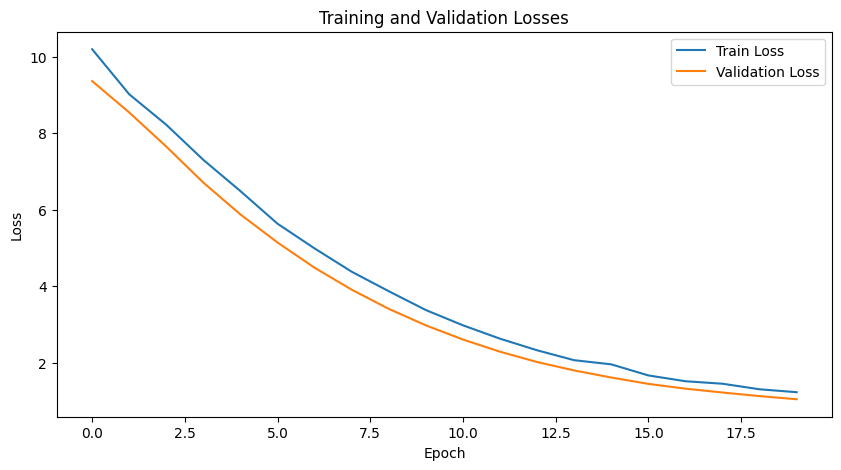

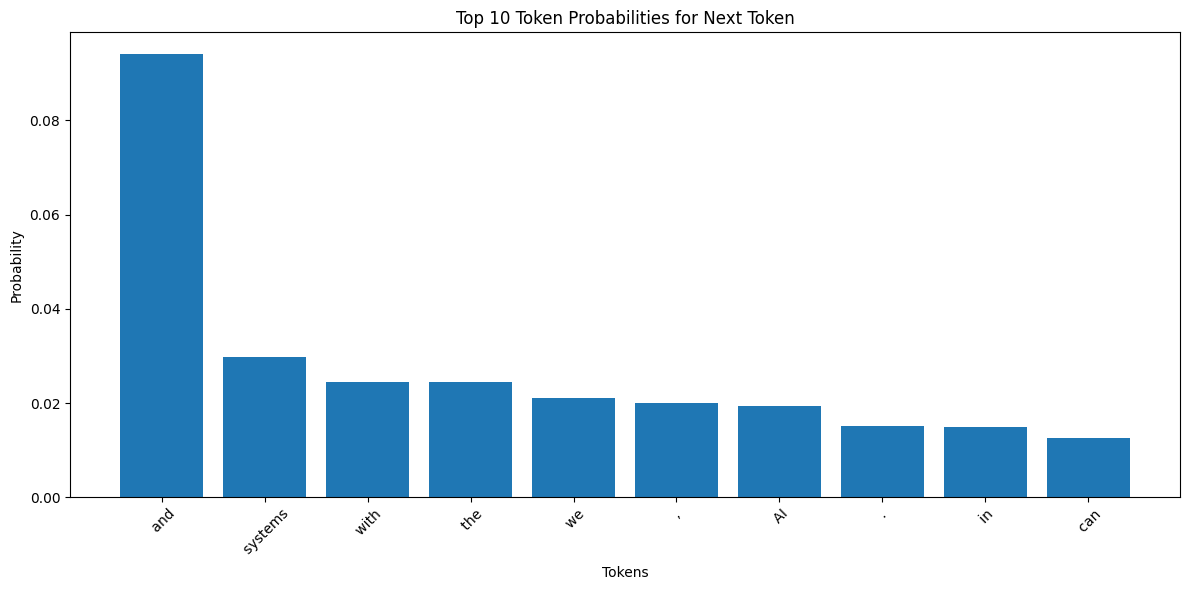

In [49]:
# Think how you would integrate this all into your main.py
config = load_config('config.yaml')
trainer = Trainer(config)
trainer.load_data(config['data_path'])

# for batch in trainer.train_dataloader:
#     inputs, targets = batch
#     print("Input:", inputs)
#     print("Target:", targets)
#     break

train_losses, val_losses = trainer.train()
trainer.plot_losses(train_losses, val_losses)

sample_input = "Once upon a time"
trainer.plot_token_probabilities(sample_input)

trainer.save_model("pseudogpt_model.pth")

#### Wow, how amazing it is to be on this stage! You've just completed an incredible journey through the world of GPT models.

Let's take a moment to appreciate what you've accomplished:

1. You've built the core components of a GPT model from scratch, including the attention mechanism, transformer blocks, and the overall model structure.
2. You've created an efficient data pipeline that processes text data into a format suitable for training language models.
3. You've implemented and executed the training loop, including forward passes, loss calculation, and backpropagation.

Congratulations, Trailblazer! Now it's time for putting GPT into action with the real problems you want to solve. Where would you like to start?